# DoE Optimality Criteria in BoFire

This tutorial notebook demonstrates the impact of different optimality-criteria for generating candidates using the DoE strategy for a two-dimensional fully-quadratic model.

## Imports

In [ ]:
import matplotlib.pyplot as plt

import bofire.strategies.api as strategies
from bofire.data_models.constraints.api import LinearEqualityConstraint
from bofire.data_models.domain.api import Domain
from bofire.data_models.features.api import ContinuousInput, ContinuousOutput
from bofire.data_models.strategies.api import DoEStrategy
from bofire.data_models.strategies.doe import (
    AOptimalityCriterion,
    DOptimalityCriterion,
    EOptimalityCriterion,
    IOptimalityCriterion,
    KOptimalityCriterion,
    SpaceFillingCriterion,
)
from bofire.strategies.doe.objective import get_objective_function

/opt/homebrew/Caskroom/miniforge/base/envs/bofire-2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Designs for different optimality criteria


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



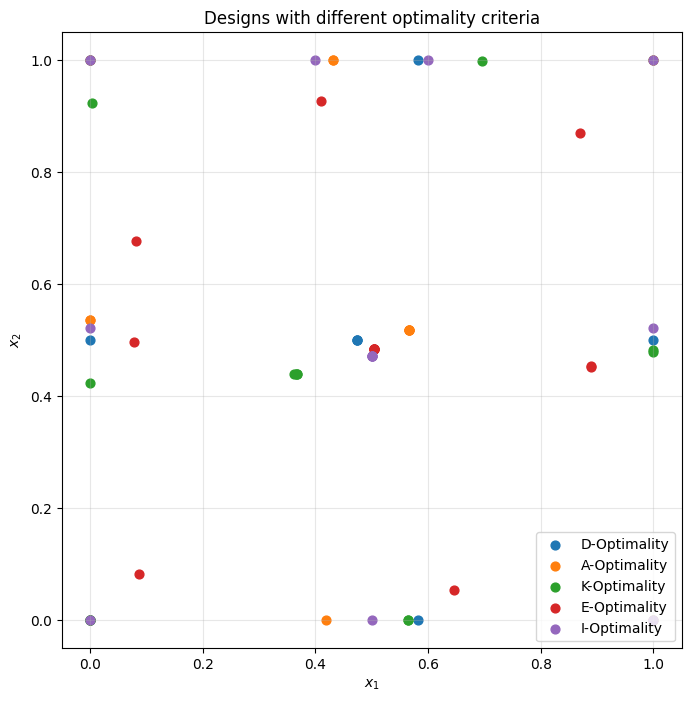

In [ ]:
# Optimal designs for a quadratic model on the unit square
domain = Domain(
    inputs=[ContinuousInput(key=f"x{i+1}", bounds=(0, 1)) for i in range(2)],
    outputs=[ContinuousOutput(key="y")],
)
model_type = "fully-quadratic"
n_experiments = 13

fig, ax = plt.subplots(figsize=(8, 8))

for crit, label in [
    (DOptimalityCriterion, "D-Optimality"),
    (AOptimalityCriterion, "A-Optimality"),
    (KOptimalityCriterion, "K-Optimality"),
    (EOptimalityCriterion, "E-Optimality"),
    (IOptimalityCriterion, "I-Optimality"),
]:
    criterion = crit(formula=model_type)
    data_model = DoEStrategy(
        domain=domain,
        criterion=criterion,
        ipopt_options={"max_iter": 300},
    )
    strategy = strategies.map(data_model=data_model)
    design = strategy.ask(candidate_count=n_experiments)
    obj_value = get_objective_function(
        criterion=criterion, domain=domain, n_experiments=n_experiments
    ).evaluate(design.to_numpy().flatten())
    ax.scatter(design.x1, design.x2, s=40, label=f"{label}")


ax.set_title("Designs with different optimality criteria")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.grid(alpha=0.3)
ax.legend()

plt.show()

## Space filling design

BoFire can also generate space filling designs, here it is show three dimensions and a simplex constraint.

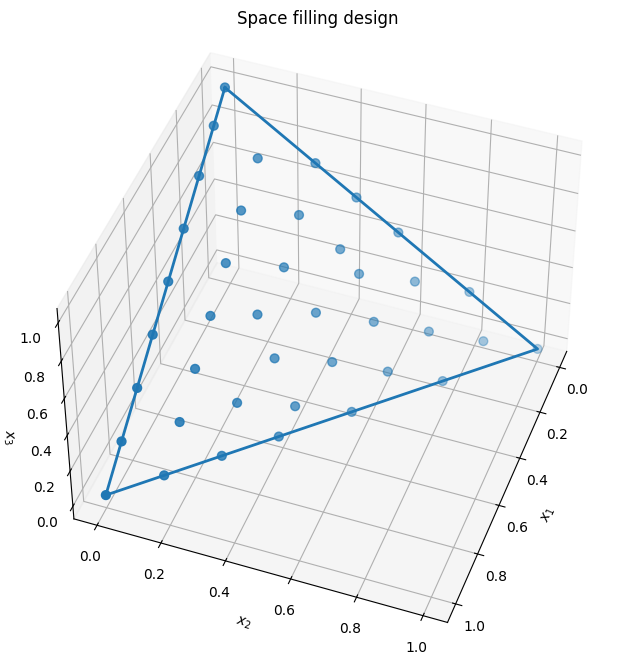

In [ ]:
# Space filling design on the unit 2-simplex
domain = Domain(
    inputs=[ContinuousInput(key=f"x{i+1}", bounds=(0, 1)) for i in range(3)],
    outputs=[ContinuousOutput(key="y")],
    constraints=[
        LinearEqualityConstraint(
            features=["x1", "x2", "x3"],
            coefficients=[1, 1, 1],
            rhs=1,
        ),
    ],
)
data_model = DoEStrategy(
    domain=domain, criterion=SpaceFillingCriterion(), ipopt_options={"max_iter": 500}
)
strategy = strategies.map(data_model=data_model)
X = strategy.ask(candidate_count=40).to_numpy()

fig = plt.figure(figsize=((10, 8)))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(45, 20)
ax.set_title("Space filling design")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")

# plot feasible polytope
ax.plot(xs=[0, 0, 1, 0], ys=[0, 1, 0, 0], zs=[1, 0, 0, 1], linewidth=2)

# plot design points
ax.scatter(xs=X[:, 0], ys=X[:, 1], zs=X[:, 2], s=40)

plt.show()